In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [2]:
# Load dataset
df = pd.read_csv("pl-tables.csv")
print(df.shape)
df.head()

(646, 12)


,season_end_year,team,position,played,won,drawn,lost,gf,ga,gd,points,notes
0,1993,Manchester Utd,1,42,24,12,6,67,31,36,84,→ Champions League via league finish
1,1993,Aston Villa,2,42,21,11,10,57,40,17,74,→ UEFA Cup via league finish
2,1993,Norwich City,3,42,21,9,12,61,65,-4,72,→ UEFA Cup via league finish 1
3,1993,Blackburn,4,42,20,11,11,68,46,22,71,NaN
4,1993,QPR,5,42,17,12,13,63,55,8,63,NaN


In [3]:
# Drop unwanted columns
df = df.drop(columns=["season_end_year","team","notes"])

# Create target variable: Winner = 1 if team finished 1st
df['Winner'] = (df['position'] == 1).astype(int)

# Drop position (to avoid leakage)
df = df.drop(columns=["position"])

df.head()


,played,won,drawn,lost,gf,ga,gd,points,Winner
0,42,24,12,6,67,31,36,84,1
1,42,21,11,10,57,40,17,74,0
2,42,21,9,12,61,65,-4,72,0
3,42,20,11,11,68,46,22,71,0
4,42,17,12,13,63,55,8,63,0


In [4]:
# Check missing values
df.isnull().sum()


played    0
won       0
drawn     0
lost      0
gf        0
ga        0
gd        0
points    0
Winner    0
dtype: int64

In [5]:
# Cleaned dataset info
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   played  646 non-null    int64
 1   won     646 non-null    int64
 2   drawn   646 non-null    int64
 3   lost    646 non-null    int64
 4   gf      646 non-null    int64
 5   ga      646 non-null    int64
 6   gd      646 non-null    int64
 7   points  646 non-null    int64
 8   Winner  646 non-null    int64
dtypes: int64(9)
memory usage: 45.6 KB


,played,won,drawn,lost,gf,ga,gd,points,Winner
count,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000
mean,38.408669,14.283282,9.842105,14.283282,51.577399,51.577399,0.000000,52.654799,0.049536
std,1.212411,5.741345,2.956505,5.401573,15.195452,13.035291,24.952482,16.499190,0.217152
min,38.000000,1.000000,2.000000,0.000000,20.000000,15.000000,-69.000000,11.000000,0.000000
25%,38.000000,10.000000,8.000000,10.250000,41.000000,43.000000,-17.000000,41.000000,0.000000
50%,38.000000,13.000000,10.000000,15.000000,48.000000,52.000000,-5.000000,50.000000,0.000000
75%,38.000000,18.000000,12.000000,18.000000,60.750000,59.750000,15.000000,63.000000,0.000000
max,42.000000,32.000000,18.000000,29.000000,106.000000,104.000000,79.000000,100.000000,1.000000


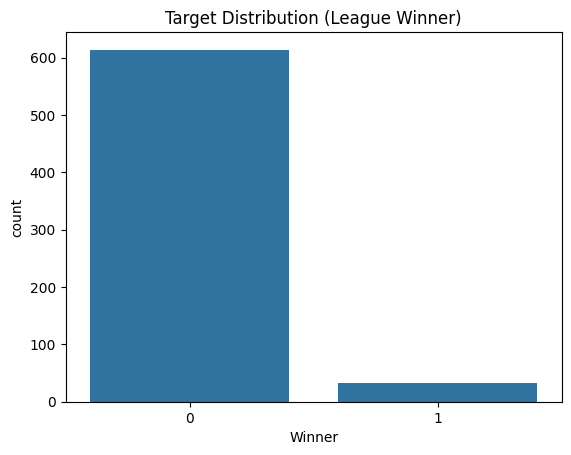

In [6]:
# Target distribution
sns.countplot(x=df['Winner'])
plt.title("Target Distribution (League Winner)")
plt.show()


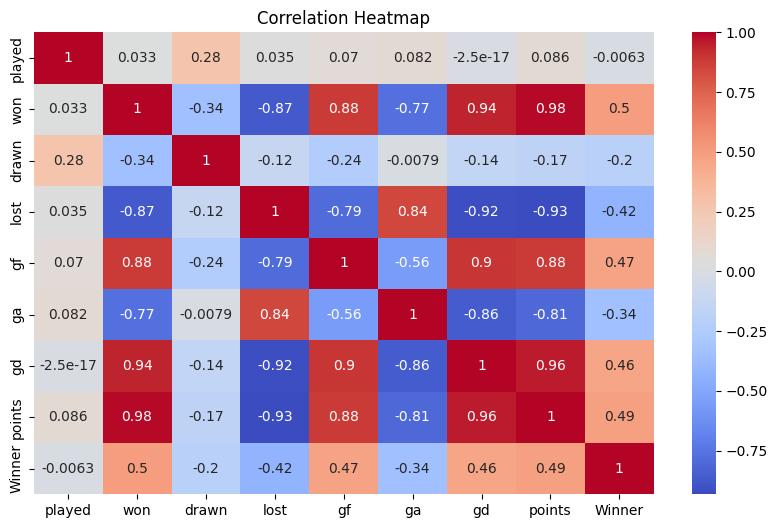

In [7]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


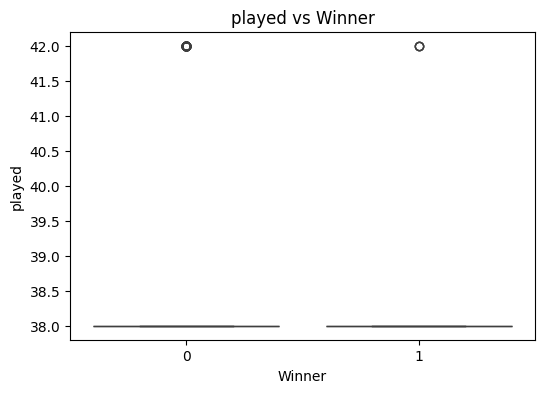

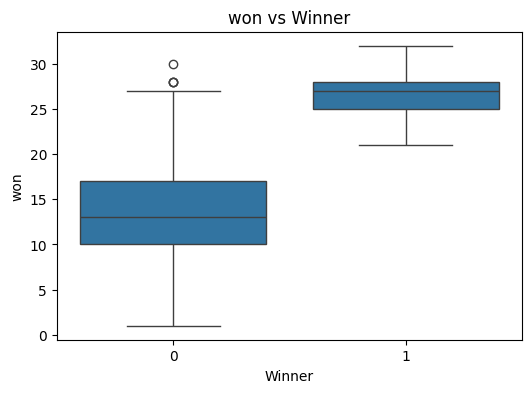

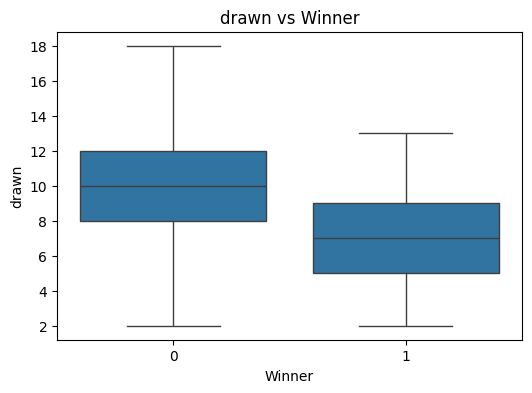

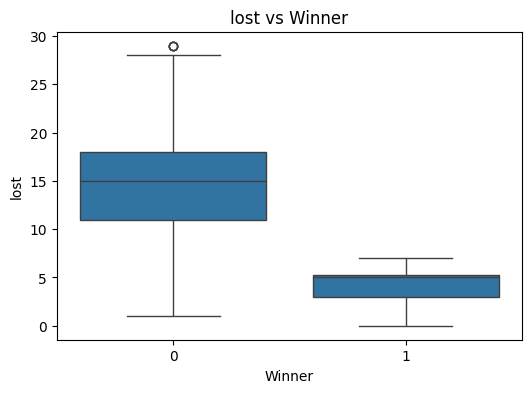

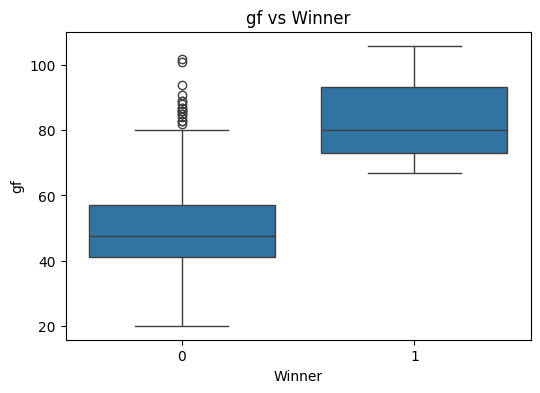

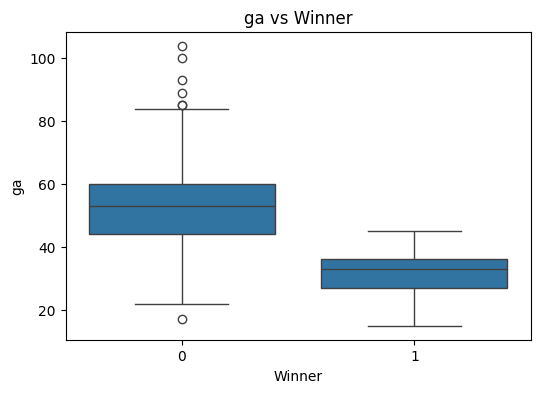

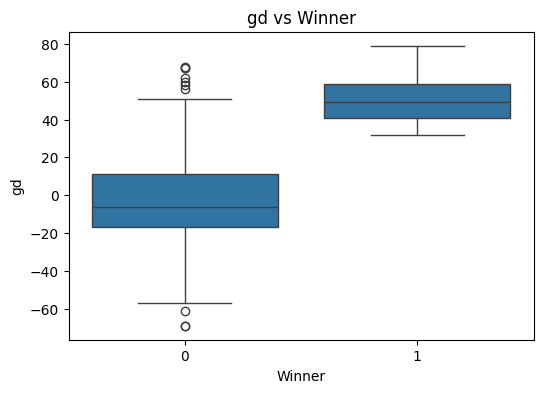

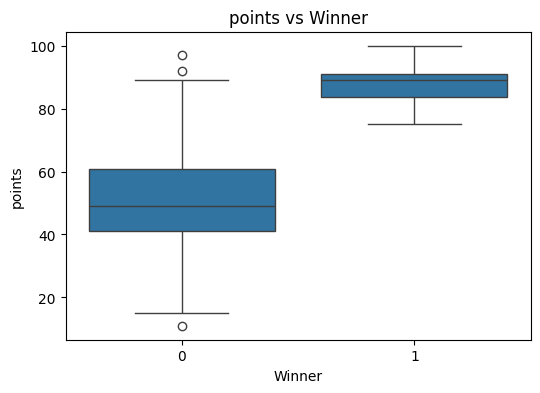

In [8]:
# Boxplot comparison: Winners vs Non-Winners
features = ['played','won','drawn','lost','gf','ga','gd','points']
for col in features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Winner', y=col, data=df)
    plt.title(f"{col} vs Winner")
    plt.show()


In [9]:
# Features and target
X = df.drop(columns=['Winner'])
y = df['Winner']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [10]:
# Helper evaluation function
def evaluate(model, X_train, y_train, X_test, y_test, name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return acc


In [11]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
acc_lr = evaluate(lr, X_train_scaled, y_train, X_test_scaled, y_test, "Logistic Regression")


Logistic Regression Accuracy: 0.9769
Confusion Matrix:
 [[124   0]
 [  3   3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       124
           1       1.00      0.50      0.67         6

    accuracy                           0.98       130
   macro avg       0.99      0.75      0.83       130
weighted avg       0.98      0.98      0.97       130



In [12]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
acc_dt = evaluate(dt, X_train, y_train, X_test, y_test, "Decision Tree")


Decision Tree Accuracy: 0.9692
Confusion Matrix:
 [[123   1]
 [  3   3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       124
           1       0.75      0.50      0.60         6

    accuracy                           0.97       130
   macro avg       0.86      0.75      0.79       130
weighted avg       0.97      0.97      0.97       130



In [13]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
acc_rf = evaluate(rf, X_train, y_train, X_test, y_test, "Random Forest")


Random Forest Accuracy: 0.9692
Confusion Matrix:
 [[123   1]
 [  3   3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       124
           1       0.75      0.50      0.60         6

    accuracy                           0.97       130
   macro avg       0.86      0.75      0.79       130
weighted avg       0.97      0.97      0.97       130



In [14]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
acc_xgb = evaluate(xgb, X_train, y_train, X_test, y_test, "XGBoost")


XGBoost Accuracy: 0.9692
Confusion Matrix:
 [[123   1]
 [  3   3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       124
           1       0.75      0.50      0.60         6

    accuracy                           0.97       130
   macro avg       0.86      0.75      0.79       130
weighted avg       0.97      0.97      0.97       130



C:\Users\rishi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:47:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [15]:
# Decision Tree Tuning
param_dt = {
    'criterion':['gini','entropy'],
    'max_depth':[3,5,10,None],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4]
}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=param_dt, cv=3, scoring='accuracy')
grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_
acc_dt_tuned = evaluate(best_dt, X_train, y_train, X_test, y_test, "Decision Tree (Tuned)")


Decision Tree (Tuned) Accuracy: 0.9692
Confusion Matrix:
 [[123   1]
 [  3   3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       124
           1       0.75      0.50      0.60         6

    accuracy                           0.97       130
   macro avg       0.86      0.75      0.79       130
weighted avg       0.97      0.97      0.97       130



In [16]:
# Random Forest Tuning
param_rf = {
    'n_estimators':[100,200],
    'max_depth':[None,10,20],
    'min_samples_split':[2,5],
    'min_samples_leaf':[1,2],
    'max_features':['sqrt','log2']
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_rf, cv=3, scoring='accuracy')
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
acc_rf_tuned = evaluate(best_rf, X_train, y_train, X_test, y_test, "Random Forest (Tuned)")


Random Forest (Tuned) Accuracy: 0.9692
Confusion Matrix:
 [[123   1]
 [  3   3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       124
           1       0.75      0.50      0.60         6

    accuracy                           0.97       130
   macro avg       0.86      0.75      0.79       130
weighted avg       0.97      0.97      0.97       130



In [20]:
# XGBoost Tuning
param_xgb = {
    'n_estimators':[100,200],
    'max_depth':[3,5,7],
    'learning_rate':[0.01,0.1,0.2]
}
grid_xgb = GridSearchCV(
    XGBClassifier(eval_metric='mlogloss', random_state=42),
    param_grid=param_xgb, cv=3, scoring='accuracy'
)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
acc_xgb_tuned = evaluate(best_xgb, X_train, y_train, X_test, y_test, "XGBoost (Tuned)")


XGBoost (Tuned) Accuracy: 0.9769
Confusion Matrix:
 [[123   1]
 [  2   4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       124
           1       0.80      0.67      0.73         6

    accuracy                           0.98       130
   macro avg       0.89      0.83      0.86       130
weighted avg       0.98      0.98      0.98       130



In [21]:
# Results comparison table
results = pd.DataFrame({
    "Model": [
        "Logistic Regression","Decision Tree","Random Forest","XGBoost",
        "Decision Tree (Tuned)","Random Forest (Tuned)","XGBoost (Tuned)"
    ],
    "Accuracy": [
        acc_lr, acc_dt, acc_rf, acc_xgb,
        acc_dt_tuned, acc_rf_tuned, acc_xgb_tuned
    ]
})
results

,Model,Accuracy
0,Logistic Regression,0.976923
1,Decision Tree,0.969231
2,Random Forest,0.969231
3,XGBoost,0.969231
4,Decision Tree (Tuned),0.969231
5,Random Forest (Tuned),0.969231
6,XGBoost (Tuned),0.976923
